# Исследование образовательной платформы

Проект был выполнен в рамках курса «Аналитик данных», Karpov_cources. 
Тема проекта – «Исследование образовательной платформы».

Задание 1. A/B–тестирование
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Задание 2. Python
Необходимо реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики. Также необходимо реализовать функцию, которая будет строить графики по получаемым метрикам.


## План работы
### 1. <a href="#A/B-тестирование">A/B-тестирование</a>
 1.1.  <a href="#Загрузка данных и ознакомление, подготовка объединенных данных">Загрузка данных и ознакомление, подготовка объединенных данных</a>   
 1.2.  <a href="#Исследовательский анализ, проверка нормальности распределения метрик: ARPU и ARPPU">Исследовательский анализ, проверка нормальности распределения метрик: ARPU и ARPPU</a>   
 1.3.  <a href="#Статистический анализ значимости различия конверсии в покупку между группами">Статистический анализ значимости различия конверсии в покупку между группами</a>  
 1.4. <a href="#Выводы">Выводы</a>
 
 
### 2. <a href="#Python">Python</a>
 2.1.  <a href="#Метрики">Метрики</a>  
 2.2.  <a href="#Графики">Графики</a>

*****

### 1. A/B-тестирование <a name ="A/B-тестирование"></a>

#### 1.1. Загрузка данных и ознакомление, подготовка объединенных данных <a name ="Загрузка данных и ознакомление, подготовка объединенных данных"></a>

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.stats import norm
from scipy.stats import chi2_contingency
from urllib.parse import urlencode

import requests
from tqdm.auto import tqdm
import pingouin as pg
import pandahouse as ph
import warnings

In [290]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [291]:
sns.set_palette("pastel")
sns.set_style('whitegrid')

Используя api, считаем файлы по ссылкам на Яндекс диск и изучим имеющиеся данные.

In [292]:
 def get_df_by_yandex_link(yandex_link):
     base_url     = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'  
     public_key   = yandex_link    
     final_url    = base_url + urlencode(dict(public_key=public_key))                 
     response     = requests.get(final_url) 
     download_url = response.json()['href']                                        
     return pd.read_csv(download_url, sep=";|,", engine ='python')    

In [293]:
 df_groups          = get_df_by_yandex_link('https://disk.yandex.ru/d/UhyYx41rTt3clQ')
 df_groups_add      = get_df_by_yandex_link('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ') 
 df_active_students = get_df_by_yandex_link('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ') 
 df_checks          = get_df_by_yandex_link('https://disk.yandex.ru/d/pH1q-VqcxXjsVA') 

*df_groups           | - файл с информацией о принадлежности пользователя к контрольной (A) или экспериментальной (B) группе  
  df_groups_add      |- дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных   
df_active_students |- файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента  
  df_checks        |  - файл с информацией об оплатах пользователей в дни проведения эксперимента*

Посмотрим на содержание файлов.

In [294]:
dfs = [df_groups, df_groups_add, df_active_students, df_checks]

In [295]:
for df in dfs:
    print (df.head(2))

     id grp
0  1489   B
1  1627   A
        id grp
0  5694584   B
1  5694830   B
   "student_id"
0        581585
1       5723133
   "student_id"  "rev"
0          1627  990.0
1          3185  690.0


Посмотрим на размер файлов.

In [296]:
for df in dfs:
    print (df.shape)

(74484, 2)
(92, 2)
(8341, 1)
(541, 2)


Предобработаем данные.
Переименуем столбцы в файлах df_active_students и df_checks.

In [297]:
df_active_students = df_active_students.rename(columns={'"student_id"': 'id'})
df_checks          = df_checks.rename(columns=({'"student_id"': 'id','"rev"': 'revenue'}))

Сравним df_groups и df_groups_add - убедимся, что id из дополнительного списка действительно не пересекаются с id из первоначального списка.

In [298]:
df_groups_updated = df_groups.merge(df_groups_add, how='outer', on='id', suffixes=['', '_new'], indicator=True)

In [299]:
df_groups_updated.head(2)

,id,grp,grp_new,_merge
0,1489,B,NaN,left_only
1,1627,A,NaN,left_only


In [300]:
df_groups_updated['_merge'].value_counts()

left_only     74484
right_only       92
both              0
Name: _merge, dtype: int64

Действительно, все id уникальные, поэтому мы можем объединим датафреймы в один df_groups_final, получим общий список пользователей, разделенных на группы.

In [301]:
df_groups_final = pd.concat([df_groups, df_groups_add],ignore_index=True)

In [302]:
df_groups_final.shape

(74576, 2)

Далее в список пользователей с информацией о группах добавим информацию о студентах, которые заходили в день эксперимента.
Мы видим, что из контрольной группы 13 тыс. студентов не заходили на платформу в день эксперимента...

In [303]:
df_groups_final['active_stud'] = df_groups_final['id'].isin(df_active_students['id'])

In [304]:
df_groups_final.groupby(['active_stud','grp']).agg({'id': 'count'})

id
active_stud grp       
False       A    13155
            B    53080
True        A     1538
            B     6803

Добавим в df_final информацию о том, кто из пользователей произвел оплату в день эксперимента.

In [305]:
df_final = df_groups_final.merge(df_checks, how='left', on='id')\
                             .fillna({'revenue': 0})                                

In [306]:
df_final['purchase'] = np.where(df_final['revenue'] <= 0, 0, 1).astype(int)

In [307]:
df_final.head(2)

,id,grp,active_stud,revenue,purchase
0,1489,B,False,0.0,0
1,1627,A,True,990.0,1


Сгруппируем данные о пользователях в зависимости от групп и активности пользователей.

In [308]:
df_final.groupby(['grp','active_stud']).agg({'id': 'count'})

id
grp active_stud       
A   False        13155
    True          1538
B   False        53080
    True          6803

Для целей проведения теста из группы А мы оставим всех пользователей (не только тех, которые заходили в день эксперимента, так как мы предполагаем, что на их поведение проведение эксперимента не влияет).
Из группы B мы оставим только тех пользователей, которые заходили в день эксперимента.
Посмотрим, что получится.

In [309]:
df_for_test = pd.concat([
    df_final.query('grp == "A"'),
    df_final.query('grp == "B" & active_stud == True')
])

In [310]:
df_for_test.head(2)

,id,grp,active_stud,revenue,purchase
1,1627,A,True,990.0,1
4,1794,A,False,0.0,0


Убедимся в корректности объединения. 

In [311]:
group_a.shape

(14693, 5)

In [312]:
group_b.shape

(6803, 5)

In [313]:
14693+6803

21496

Структура полученного датасета:

In [314]:
df_for_test.groupby(['grp', 'active_stud', 'purchase']).agg({'id': 'count'})

id
grp active_stud purchase       
A   False       0         13126
                1            29
    True        0          1460
                1            78
B   True        0          6489
                1           314

Сравним средние чеки по группам - мы видим, что разница между группами А и В подозрительно большая (6 и 58).   
Очень сильно понижают показатель данные неактивных в день эксперимента пользователей группы А.  

In [315]:
#Средний чек по всей группе А
df_for_test.revenue[df_for_test.grp == 'A'].sum()/df_for_test.revenue[df_for_test.grp == 'A'].count()

6.268018784455183

In [316]:
#Средний чек по всей группе B
df_for_test.revenue[df_for_test.grp == 'B'].sum()/df_for_test.revenue[df_for_test.grp == 'B'].count()

58.058798103777754

In [317]:
# Средний чек по группе А где только пассивные пользователи
df_for_test.query('active_stud == False & grp == "A"').revenue.sum()/   \
df_for_test.query('active_stud == False & grp == "A"').revenue.count()

1.4652983656404408

In [318]:
# Средний чек по группе А где только активные пользователи
df_for_test.query('active_stud == True & grp == "A"').revenue.sum()/   \
df_for_test.query('active_stud == True & grp == "A"').revenue.count()

47.34720416124838

Изменим наш подход к формированию датасета в части пользователей группы А: оставим в ней всех активных пользователей, а также неактивных, но по которым прошли оплаты в день эксперимента (29 человек). 
Мы считаем это логичным, так как оплаты по этим пользователям являются косвенным свидетельством их активности на платформе (возможно настроен автоплатеж). Из группы B мы также оставим только тех пользователей, которые заходили в день эксперимента.

In [319]:
df_for_test_new = pd.concat([
    df_final.query('grp == "A" & purchase == 1 & active_stud == False'),
    df_final.query('grp == "A" & active_stud == True'),
    df_final.query('grp == "B" & active_stud == True')
])
df_for_test_new['revenue'] = df_for_test_new['revenue'].astype('int')

Структура обновленного датасета:

In [320]:
df_for_test_new.groupby(['grp', 'active_stud', 'purchase']).agg({'id': 'count'})

id
grp active_stud purchase      
A   False       1           29
    True        0         1460
                1           78
B   True        0         6489
                1          314

In [321]:
#Обновленный средний чек по всей группе А
df_for_test_new.revenue[df_for_test_new.grp == 'A'].sum()/df_for_test_new.revenue[df_for_test_new.grp == 'A'].count()

58.77217613273771

### 2. Исследовательский анализ, проверка нормальности распределения метрик: ARPU и ARPPU <a name ="Исследовательский анализ, проверка нормальности распределения метрик: ARPU и ARPPU"></a>

Перед проведением А/B-тестирования необходимо убедиться в том, что результатам эксперимента можно будет доверять.  
Для этого необходимо исследовать данные, которые будут лежать в его основе, выявить их особенности и учесть их при выборе статистического критерия. 

У нас недостаточно данных, для того, чтобы оценить однородность выборки.  
Также мы не знаем размер генеральной совокупности, у нас есть только выборка.

Сравним количество пользователей в группах А и В.  
Количество пользователей в группах различается: А (контроль) - 1.5 тыс. и  В (целевая) - 6.8 тыс. 
Мы не ожидаем, что данная разница повлияет на результаты теста, если между группами нет различий.
Разделение на тестовые группы обычно производится таким образом, чтобы минимизировать затраты и быстрее получить результат. Если мы готовы внедрить новый механизм оплаты на 80% пользователей, то так за то же самое время мы соберем больше данных, чем если бы пользователи были разделены между группами 50/50.

In [322]:
df_for_test_new.groupby('grp').agg({'id': 'count'})

,id
grp,
A,1567
B,6803


Убедимся, что группы одновременно проводимых тестов не пересекаются.  
Это действительно так - количество уникальных id пользователей соответствует общему количеству id в таблице.  
Каждому пользователю доступна только одна опция оплаты.

In [323]:
df_for_test_new.nunique()

id             8370
grp               2
active_stud       2
revenue          38
purchase          2
dtype: int64

In [324]:
df_for_test_new.shape

(8370, 5)

Чтобы оценить эффект от внедрения новой механики оплаты услуг на сайте, основываясь на имеющихся данных, будем использовать три ключевые метрики:  
1. CR (конверсия)  
2. ARPU (средняя выручка на пользователя)  
3. ARPPU (средняя выручка на платящего пользователя)
    

1. CR - отношение пользователей, совершивших оплату к общему количеству пользователей, посетивших сайт во время эксперимента.   
Посмотрим, как данная метрика отличается между группами.  
CR между группами: контрольная группа - 6.8%, целевая - 4.6%.  
То есть с введением новой механики оплаты CR сократился.

In [325]:
CR = df_for_test_new.groupby('grp')['purchase'].mean()
CR

grp
A    0.068283
B    0.046156
Name: purchase, dtype: float64

Конверсия в покупку - метрика, рассчитываемая на основе категориальных переменных (фактах совершения покупки), характеризуемых распределением Бернулли, поэтому проверку нормальности распределения для CR мы проводить не будем.

2. ARPU (средняя выручка на пользователя)  

Рассчитаем ARPU по группам.

In [326]:
ARPU = df_for_test_new.groupby('grp')['revenue'].mean()
ARPU

grp
A    58.772176
B    58.058798
Name: revenue, dtype: float64

Из описательной статистики мы видим, что в целом, распределения похожи между собой.  

In [327]:
df_for_test_new.revenue[df_for_test.grp == 'A'].describe()

count    1567.000000
mean       58.772176
std       303.678591
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3660.000000
Name: revenue, dtype: float64

In [328]:
df_for_test_new.revenue[df_for_test.grp == 'B'].describe()

count    6803.000000
mean       58.058798
std       313.770198
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: revenue, dtype: float64

Визуализируем распределения значений выручки, лежащих в основе расчета среднего чека ARPU.  
Очевидно, что распределения ненормальные - присутствует множество нулевых значений, которые не позволяют их трансформировать и привести к виду, более похожему на нормальное. 

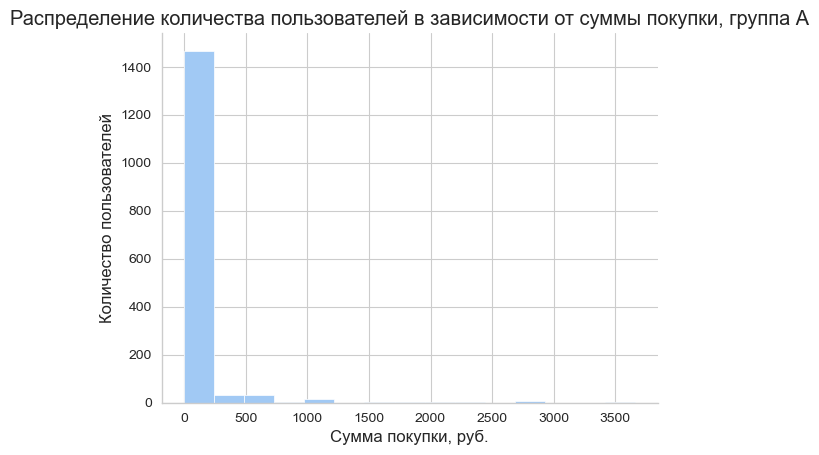

In [329]:
df_for_test_new.revenue[df_for_test_new.grp == 'A'].hist(bins=15)
plt.title('Распределение количества пользователей в зависимости от суммы покупки, группа А')
plt.xlabel('Сумма покупки, руб.')
plt.ylabel('Количество пользователей')
sns.despine()

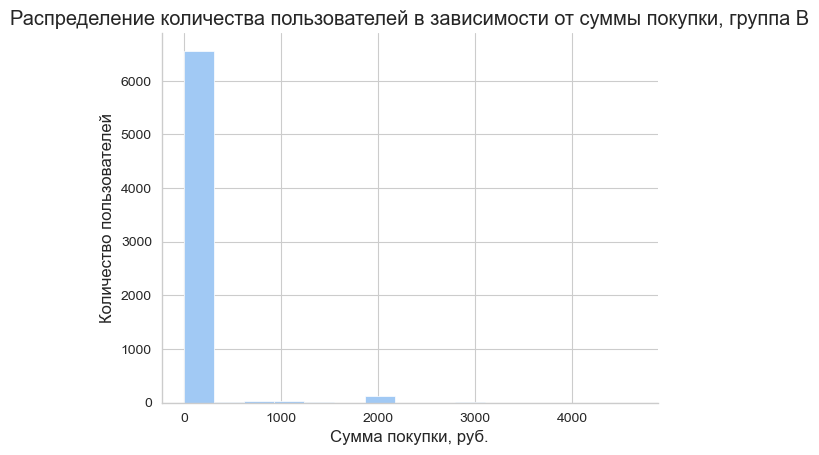

In [330]:
df_for_test_new.revenue[df_for_test_new.grp == 'B'].hist(bins=15)
plt.title('Распределение количества пользователей в зависимости от суммы покупки, группа В')
plt.xlabel('Сумма покупки, руб.')
plt.ylabel('Количество пользователей')
sns.despine()

In [331]:
df_for_test_new.groupby(['purchase', 'grp']).agg({'id': 'count'})

id
purchase grp      
0        A    1460
         B    6489
1        A     107
         B     314

3. ARPPU (средняя выручка на платящего пользователя) по группам существенно увеличилась.

Для расчета ARPPU отберем только платящих пользователей.

In [332]:
df_paid = df_for_test_new.query('purchase == 1')

Их количество в группах А и В - около 100 и 300 соответственно.

In [333]:
df_paid.groupby('grp').agg({'id': 'count'})

,id
grp,
A,107
B,314


In [334]:
ARPPU = df_paid.groupby('grp')['revenue'].mean()
ARPPU

grp
A     860.710280
B    1257.878981
Name: revenue, dtype: float64

Посмотрим на описательные статистики распределений

In [335]:
df_paid.query('grp == "A"').revenue.describe()

count     107.000000
mean      860.710280
std       815.893445
min       199.000000
25%       290.000000
50%       690.000000
75%       990.000000
max      3660.000000
Name: revenue, dtype: float64

In [336]:
df_paid.query('grp == "B"').revenue.describe()

count     314.000000
mean     1257.878981
std       790.864245
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: revenue, dtype: float64

Визуализируем распределения. Проверим нормальность распределений.

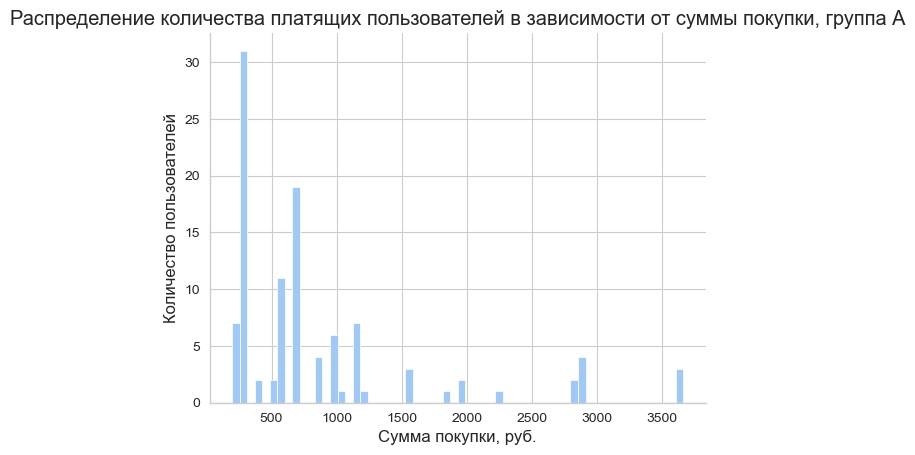

In [337]:
df_paid.query('grp == "A"').revenue.hist(bins=60)
plt.title('Распределение количества платящих пользователей в зависимости от суммы покупки, группа А')
plt.xlabel('Сумма покупки, руб.')
plt.ylabel('Количество пользователей')
sns.despine()

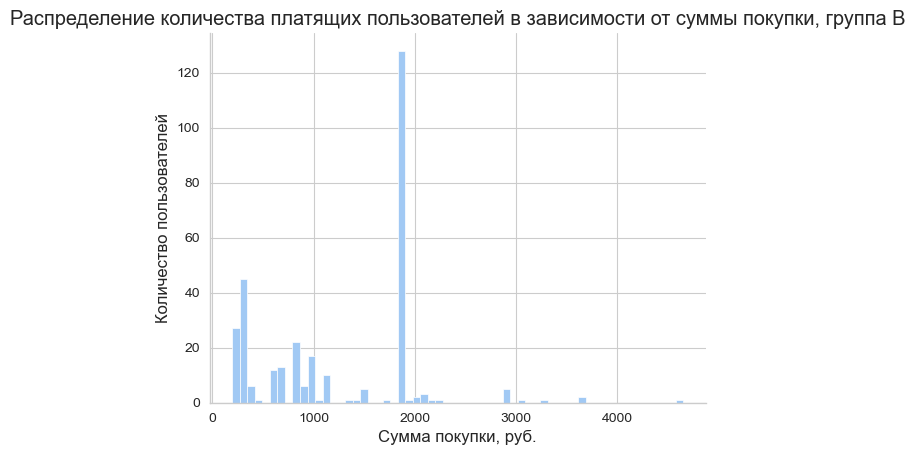

In [338]:
df_paid.query('grp == "B"').revenue.hist(bins=60)
plt.title('Распределение количества платящих пользователей в зависимости от суммы покупки, группа В')
plt.xlabel('Сумма покупки, руб.')
plt.ylabel('Количество пользователей')
sns.despine()

Построим боксплот для платящих пользователей.  
Видим, что есть выбросы, которые влияют на значение ARPPU.

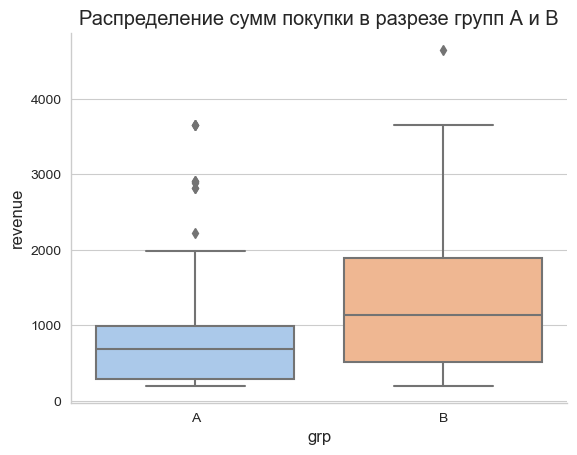

In [339]:
ax = sns.boxplot(x='grp' ,y='revenue' , data=df_paid)
plt.title('Распределение сумм покупки в разрезе групп А и В')
sns.despine()

Попробуем трансформировать данные с помощью логарифмирования.  
Выбросы ушли, но распределение не стало нормальным. Наблюдается явная ассимметрия.

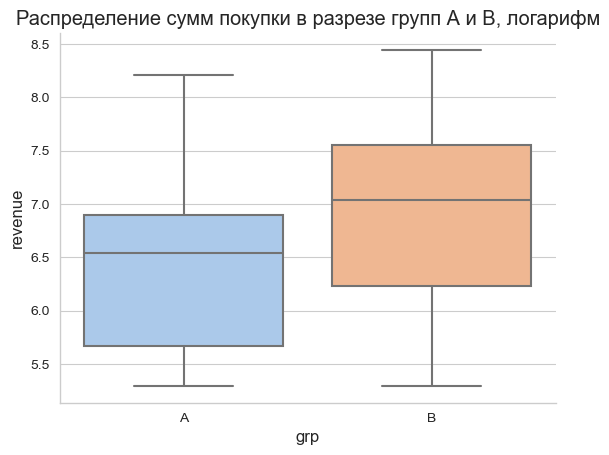

In [340]:
ax = sns.boxplot(x='grp', y=np.log(df_paid['revenue']), data=df_paid)
plt.title('Распределение сумм покупки в разрезе групп А и В, логарифм')
sns.despine()

На графике ниже хорошо видно, что в данных группы В присутствует значение, существенно отличающееся от других.

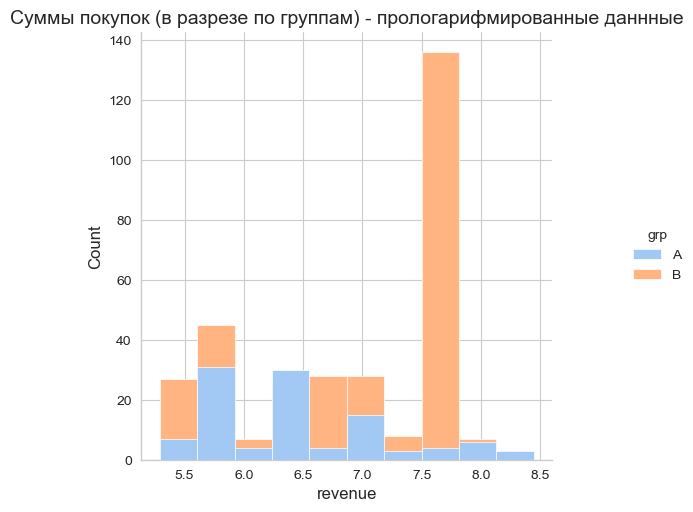

In [341]:
sns.displot(x=np.log(df_paid['revenue']), data=df_paid, hue='grp', alpha=1)
plt.title('Суммы покупок (в разрезе по группам) - прологарифмированные даннные', fontsize=14)
sns.despine()

Мы видим, что в целевой группе достаточно большая часть пользователей совершили покупку на сумму 1900 руб., в то время как в контрольной группе покупок на данную сумму совершено не было. Скорее всего, это связано с именно с нововведением по оплате - мы может только предположить, что конкретно это могло быть - акционное предложение, либо переход от разовой оплаты к оплате по абонементу. 

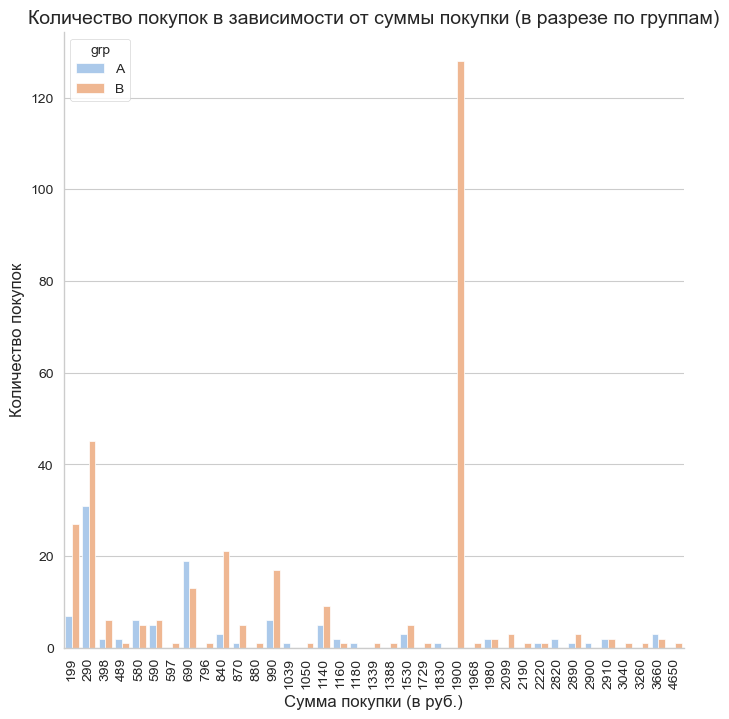

In [342]:
plt.figure(figsize=(8,8))
ax_ = sns.countplot(x = df_paid['revenue'].round(0), hue='grp', data=df_paid, alpha=1);

plt.xticks(rotation=90, fontsize=10)
sns.despine()

ax_.set_xlabel('Сумма покупки (в руб.)', fontsize=12)
ax_.set_ylabel('Количество покупок', fontsize=12)
ax_.set_title('Количество покупок в зависимости от суммы покупки (в разрезе по группам)', fontsize=14)

plt.show()

In [343]:
print(f"""Таким образом, в результате проведенного исследовательского анализа мы пришли к следующим выводам:
1. CR (конверсия в покупку) снизилась: 
Группа А - {round(df_for_test_new.purchase[df_for_test.grp == 'A'].mean(),2)},
Группа В - {round(df_for_test_new.purchase[df_for_test.grp == 'B'].mean(),2)}.
2. ARPU (средняя выручка на пользователя) снизилась незначительно, осталась примерно на том же уровне:
Группа А - {round(df_for_test_new.revenue[df_for_test.grp == 'A'].mean(),2)},
Группа В - {round(df_for_test_new.revenue[df_for_test.grp == 'B'].mean(),2)}. 
3. ARPPU - (средняя выручка на платящего пользователя) выросла:
Группа А - {round(df_paid.query('grp == "A"').revenue.mean(),2)},
Группа В - {round(df_paid.query('grp == "B"').revenue.mean(),2)}.""") 


Таким образом, в результате проведенного исследовательского анализа мы пришли к следующим выводам:
1. CR (конверсия в покупку) снизилась: 
Группа А - 0.07,
Группа В - 0.05.
2. ARPU (средняя выручка на пользователя) снизилась незначительно, осталась примерно на том же уровне:
Группа А - 58.77,
Группа В - 58.06. 
3. ARPPU - (средняя выручка на платящего пользователя) выросла:
Группа А - 860.71,
Группа В - 1257.88.


### 3. Статистический анализ значимости различия конверсии в покупку между группами <a name ="Статистический анализ значимости различия конверсии в покупку между группами"></a>

Нам необходимо понять, отличаются ли статистически значимо значения метрики в экспериментальной (целевой) группе от аналогичной метрики в контрольной группе. Протестируем каждую метрику:
1. CR    - хи-квадрат (номинальные переменные, наблюдения независимы, количество купивших/не купивших больше 5)
2. ARPU  - bootstrap 
3. ARPPU - bootstrap

Уровень значимости для каждого из тестов - 5%.

#### 1. CR.  
Нулевая гипотеза H0        - введение новой системы оплаты не повлияет на CR, средние равны. 
Альтернативная гипотеза H1 - введение новой системы оплаты повлияет на CR, средние отличаются. 

Создадим таблицу сопряжённости для проведения анализа chi2_contingency.

In [344]:
crosstab = pd.crosstab(df_for_test_new.grp, df_for_test_new.purchase)
crosstab

purchase,0,1
grp,,
A,1460,107
B,6489,314


In [345]:
a_noclick = crosstab.loc['A', 0]
a_click   = crosstab.loc['A', 1]
b_noclick = crosstab.loc['B', 0]
b_click   = crosstab.loc['B', 1]

In [346]:
T = np.array([[a_noclick, a_click], [b_noclick, b_click]])
T

array([[1460,  107],
       [6489,  314]], dtype=int64)

In [347]:
p_value_chi2 = chi2_contingency(T,correction=False)[1].round(4)
p_value_chi2

0.0003

In [348]:
print(f"""Уровень значимости составляет {p_value_chi2} < альфа = 0.05.   
Основания для отклонения нулевой гипотезы есть.
Принимаем альтернативную гипотезу.""")

Уровень значимости составляет 0.0003 < альфа = 0.05.   
Основания для отклонения нулевой гипотезы есть.
Принимаем альтернативную гипотезу.


### Определим функцию для работы bootstrap

In [349]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [350]:
a = df_for_test_new.query('grp == "A"')
b = df_for_test_new.query('grp == "B"')

#### 2. ARPU 
Исходные условия:
 - ARPU - метрика, основанная на непрерывных количественных переменных (данных о сумме покупок)
 - данные характеризуются неправильным распределением с большим количеством нулевых значений
 
Нулевая гипотеза H0        - введение новой системы оплаты не повлияет на ARPU, средние равны.  
Альтернативная гипотеза H1 - введение новой системы оплаты повлияет на ARPU, средние отличаются.  
Выбранный метод тестирования - bootstrap.

  0%|          | 0/1000 [00:00<?, ?it/s]

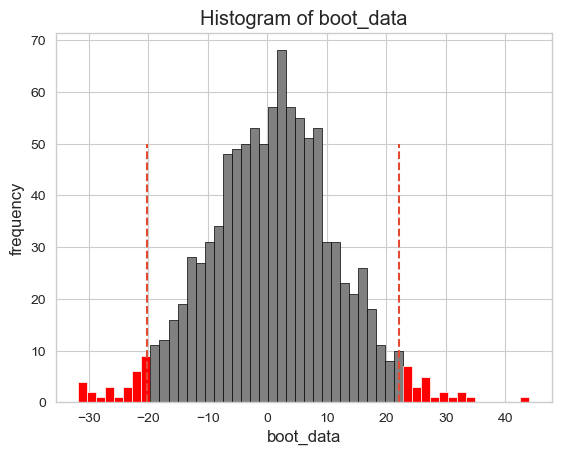

In [351]:
ARPU_booted_data = get_bootstrap(a.revenue, b.revenue)

In [352]:
ARPU_booted_data["p_value"]

0.9320176040866713

In [353]:
ARPU_booted_data["quants"]

,0
0.025,-20.261886
0.975,22.055648


In [354]:
print(f"""Уровень значимости составляет {ARPU_booted_data["p_value"].round(2)} > 0.05, что в целом не позволяет нам отклонить нулевую гипотезу и принять альтернативную.   
В найденный доверительный интервал попадает 0, что означает, что мы не можем быть уверены в том, что настоящий эффект отличен от нуля и имеет статистическую значимость.
Оснований для отклонения нулевой гипотезы нет.""")

Уровень значимости составляет 0.93 > 0.05, что в целом не позволяет нам отклонить нулевую гипотезу и принять альтернативную.   
В найденный доверительный интервал попадает 0, что означает, что мы не можем быть уверены в том, что настоящий эффект отличен от нуля и имеет статистическую значимость.
Оснований для отклонения нулевой гипотезы нет.


#### 3. ARPPU

Исходные условия:
 - ARPPU - метрики, основанные на непрерывных количественных переменных (данных о сумме покупок)
 - данные характеризуются неправильным распределением, даже при логарифмировании ARPPU не становится близким к нормальному.
 
Нулевая гипотеза H0        - введение новой системы оплаты не повлияет на ARPPU, средние равны.  
Альтернативная гипотеза H1 - введение новой системы оплаты повлияет на ARPPU, средние отличаются.  
Выбранный метод тестирования - bootstrap.

In [355]:
a_ = df_paid.query('grp == "A"')
b_ = df_paid.query('grp == "B"')

  0%|          | 0/1000 [00:00<?, ?it/s]

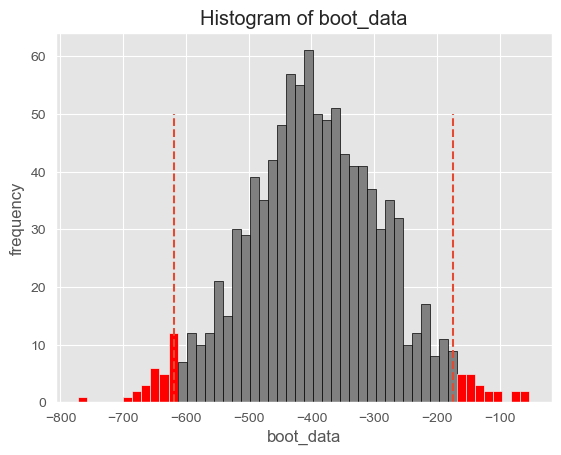

In [356]:
ARPPU_booted_data = get_bootstrap(a_.revenue, b_.revenue)

In [357]:
ARPPU_booted_data["p_value"]

0.0003172335304332681

In [358]:
ARPPU_booted_data["quants"]

,0
0.025,-618.405841
0.975,-174.205140


In [359]:
print(f"""Уровень значимости составляет {ARPPU_booted_data["p_value"].round(4)} < 0.05, что позволяет нам отклонить нулевую гипотезу и принять альтернативную.   
В найденный доверительный интервал не попадает 0, что в целом означает, что мы можем быть уверены в том, что настоящий эффект отличен от нуля и имеет статистическую значимость.   
Однако мы получили полностью отрицательные значения доверительного интервала, что может быть результатом разных обстоятельств:
- слишком большая разница между метриками (Группа А - {round(df_paid.query('grp == "A"').revenue.mean(),2)}, Группа В - {round(df_paid.query('grp == "B"').revenue.mean(),2)})
- некорректно сформированная выборка.""")

Уровень значимости составляет 0.0003 < 0.05, что позволяет нам отклонить нулевую гипотезу и принять альтернативную.   
В найденный доверительный интервал не попадает 0, что в целом означает, что мы можем быть уверены в том, что настоящий эффект отличен от нуля и имеет статистическую значимость.   
Однако мы получили полностью отрицательные значения доверительного интервала, что может быть результатом разных обстоятельств:
- слишком большая разница между метриками (Группа А - 860.71, Группа В - 1257.88)
- некорректно сформированная выборка.


### Выводы <a name ="Выводы"></a>

In [360]:
print(f"""1. CR (конверсия в покупку).   
Хи-квадрат: {p_value_chi2} < 0.05.  
Основания для отклонения нулевой гипотезы есть. Принимаем альтернативную гипотезу.  
Группа А - {round(df_for_test_new.purchase[df_for_test.grp == 'A'].mean(),3)},
Группа В - {round(df_for_test_new.purchase[df_for_test.grp == 'B'].mean(),3)}. 

Считаем, что снижение CR до {round(df_for_test_new.purchase[df_for_test.grp == 'B'].mean(),3)} статистически значимо.

2. ARPU (средняя выручка на пользователя)
Bootstrap анализ: {ARPU_booted_data["p_value"].round(2)} > 0.05, в найденный доверительный интервал попадает 0.  
Оснований для отклонения нулевой гипотезы нет.  
Группа А - {round(df_for_test_new.revenue[df_for_test.grp == 'A'].mean(), 2)},
Группа В - {round(df_for_test_new.revenue[df_for_test.grp == 'B'].mean(), 2)}. 

Считаем, что снижение ARPU не является статистически значимым.

3. ARPPU - (средняя выручка на платящего пользователя)  
Bootstrap анализ  - {ARPPU_booted_data["p_value"].round(4)} < 0.05.
В найденный доверительный интервал не попадает 0, однако доверительный интервал состоит из отрицательных значений.
     
Основания для отклонения нулевой гипотезы есть.    
Группа А - {round(df_paid.query('grp == "A"').revenue.mean(), 2)},
Группа В - {round(df_paid.query('grp == "B"').revenue.mean(), 2)}.

Считаем, что увеличение ARPPU является статистически значимым.""")

1. CR (конверсия в покупку).   
Хи-квадрат: 0.0003 < 0.05.  
Основания для отклонения нулевой гипотезы есть. Принимаем альтернативную гипотезу.  
Группа А - 0.068,
Группа В - 0.046. 

Считаем, что снижение CR до 0.046 статистически значимо.

2. ARPU (средняя выручка на пользователя)
Bootstrap анализ: 0.93 > 0.05, в найденный доверительный интервал попадает 0.  
Оснований для отклонения нулевой гипотезы нет.  
Группа А - 58.77,
Группа В - 58.06. 

Считаем, что снижение ARPU не является статистически значимым.

3. ARPPU - (средняя выручка на платящего пользователя)  
Bootstrap анализ  - 0.0003 < 0.05.
В найденный доверительный интервал не попадает 0, однако доверительный интервал состоит из отрицательных значений.
     
Основания для отклонения нулевой гипотезы есть.    
Группа А - 860.71,
Группа В - 1257.88.

Считаем, что увеличение ARPPU является статистически значимым.


По результатам А/В теста CR снизился на 2.2%, ARPPU увеличился на 46%, изменение ARPU подтвердить не удалось.  
В качестве дальнейших действий небходимо:
- проверить корректность работы системы сплитования, провести А/А тест;
- если есть пользователи, у которых настроен автоплатеж, учитывать их при сплитовании так, чтобы они не попали в целевую группу;
- выяснить, что стало причиной появления экстремальных значений в выборке по группе В и далее в соответствии с этим выбрать наиболее подходящую методику тестирования;
- если есть возможность, пока не раскатывать новую оплату на всех пользователей, продолжить эксперимент, понаблюдать за конверсией.

## 2. Python  <a name ="Python"></a>

### 2.1. Метрики <a name ="Метрики"></a>

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Представим ситуацию, когда анализ выше (в первом задании) еще не был проведен. Имеется датафрейм с данными о пользователях для проведения А/В теста, и через какое время команда нашла ошибку в сплитовании и решила добавить пользователей в имеющийся датафрейм.  

Подготовим датафрейм и метрики, которые нужно будет обновить:
- к списку студентов с разделением на группы добавим информацию об  активности студентов в день эксперимента в булевом виде
- присоединим данные из таблицы о покупках
- добавим информацию о совершенных покупках в булевом виде 0/1

In [361]:
df_groups_1 = df_groups
df_groups_1 ['active_stud'] = df_groups_1['id'].isin(df_active_students['id'])
df_groups_at_work = df_groups_1.merge(df_checks, how='left', on='id')\
                             .fillna({'revenue': 0}) 
df_groups_at_work['purchase'] = df_groups_at_work['revenue'].apply(lambda x: '0' if x <= 0 else '1').astype(int)
df_groups_at_work.head()

,id,grp,active_stud,revenue,purchase
0,1489,B,False,0.0,0
1,1627,A,True,990.0,1
2,1768,B,False,0.0,0
3,1783,B,False,0.0,0
4,1794,A,False,0.0,0


In [362]:
group_a_3  = df_groups_at_work.query('grp == "A" & purchase == 1 & active_stud == False')
group_a_3_ = df_groups_at_work.query('grp == "A" & active_stud == True')
group_b_3  = df_groups_at_work.query('grp == "B" & active_stud == True')

Получим финальный датасет до обновления

In [363]:
df_groups_at_work_final = pd.concat([
                                     df_groups_at_work.query('grp == "A" & purchase == 1 & active_stud == False'),
                                     df_groups_at_work.query('grp == "A" & active_stud == True'),
                                     df_groups_at_work.query('grp == "B" & active_stud == True')
                                    ])
df_groups_at_work_final

,id,grp,active_stud,revenue,purchase
406,114366,A,False,690.0,1
2041,212994,A,False,690.0,1
2231,218393,A,False,690.0,1
2393,225541,A,False,690.0,1
2969,243614,A,False,690.0,1
...,...,...,...,...,...
74447,5678521,B,True,0.0,0
74452,5681918,B,True,1900.0,1
74456,5685258,B,True,0.0,0
74461,5688310,B,True,0.0,0


На основании данного файла мы рассчитываем метрики и записываем их в датасет

In [364]:
# CR (конверсия в покупку)
CR_A = df_groups_at_work_final.purchase[df_groups_at_work_final.grp == 'A'].mean()
CR_B = df_groups_at_work_final.purchase[df_groups_at_work_final.grp == 'B'].mean()

# ARPU (средняя выручка на пользователя) 
ARPU_A = df_groups_at_work_final.revenue[df_groups_at_work_final.grp == 'A'].mean()
ARPU_B = df_groups_at_work_final.revenue[df_groups_at_work_final.grp == 'B'].mean()

# ARPPU - (средняя выручка на платящего пользователя  
ARPPU_A = df_groups_at_work_final.query('grp == "A" & purchase == 1').revenue.mean()
ARPPU_B = df_groups_at_work_final.query('grp == "B" & purchase == 1').revenue.mean()
         
metrics_data =[['CR_A', CR_A], ['CR_B', CR_B], ['ARPU_A', ARPU_A], ['ARPU_B', ARPU_B], ['ARPPU_A', ARPPU_A], ['ARPPU_B',ARPPU_B]]

df_metrics = pd.DataFrame(data=metrics_data, columns=['name', 'value'])         

In [365]:
df_metrics

,name,value
0,CR_A,0.068414
1,CR_B,0.046077
2,ARPU_A,58.884910
3,ARPU_B,57.864567
4,ARPPU_A,860.710280
5,ARPPU_B,1255.827487


Мы получили файл с дополнительным списком пользователей df_groups_add. Необходимо, чтобы данные из этого файла на этапе формирования общего датасета обновляли файл df_groups, и далее все остальные расчеты происходили аналогичным образом.
Напишем для этого функцию.

In [366]:
""""Прочитаем файл с помощью написанной ранее функции.
    Дополним первоначальный список студентов информацией из нового файла.
    Добавим столбец с информацией об активности студентов.
    Добавим суммы покупок и создадим новый датафрейм.
    Добавим столбец с информацией об оплатах (0/1).
    Выберем необходимые категории студентов и сформируем финальный обновленный датафрейм.
    
    Рассчитаем обновленные метрики и запишем их в датафрейм.""""
    

def update_metrics(df_groups_add):
    df_groups_add = get_df_by_yandex_link('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
    df_groups_update = pd.concat([df_groups_1.iloc[:, [0,1]],df_groups_add.iloc[:, [0,1]]])  
    df_groups_update ['active_stud'] = df_groups_update['id'].isin(df_active_students['id']) 
    df_groups_at_work_update = df_groups_update.merge(df_checks, how = 'left', on = 'id').fillna({'revenue': 0}) 
    df_groups_at_work_update['purchase'] = np.where(df_groups_at_work_update['revenue'] <= 0, 0, 1).astype(int)
    
    df_groups_at_work_final_update = pd.concat([
        df_groups_at_work_update.query('grp == "A" & purchase == 1 & active_stud == False'),
        df_groups_at_work_update.query('grp == "A" & active_stud == True'),
        df_groups_at_work_update.query('grp == "B" & active_stud == True')
    ])

    # CR
    CR_A = df_groups_at_work_final_update.purchase[df_groups_at_work_final_update.grp == 'A'].mean()
    CR_B = df_groups_at_work_final_update.purchase[df_groups_at_work_final_update.grp == 'B'].mean()

    # ARPU 
    ARPU_A = df_groups_at_work_final_update.revenue[df_groups_at_work_final_update.grp == 'A'].mean()
    ARPU_B = df_groups_at_work_final_update.revenue[df_groups_at_work_final_update.grp == 'B'].mean()

    # ARPPU  
    ARPPU_A = df_groups_at_work_final_update.query('grp == "A" & purchase == 1').revenue.mean()
    ARPPU_B = df_groups_at_work_final_update.query('grp == "B" & purchase == 1').revenue.mean()
         
    metrics_data =[['CR_A', CR_A], ['CR_B', CR_B], ['ARPU_A', ARPU_A], ['ARPU_B', ARPU_B], ['ARPPU_A', ARPPU_A], ['ARPPU_B',ARPPU_B]]

    df_metrics_update = pd.DataFrame(data = metrics_data, columns = ['name', 'value'])         

    return df_metrics_update

In [367]:
df_metrics_update = update_metrics(df_groups_add)
df_metrics_update

,name,value
0,CR_A,0.068283
1,CR_B,0.046156
2,ARPU_A,58.772176
3,ARPU_B,58.058798
4,ARPPU_A,860.710280
5,ARPPU_B,1257.878992


### 2.2. Графики <a name ="Графики"></a>

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

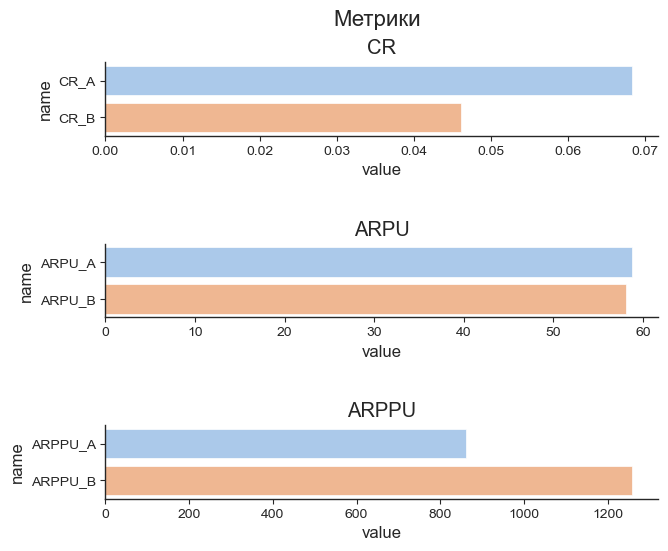

In [370]:
def plot_metrics_data(df_metrics_update):
    sns.set_style('ticks')
    sns.set_palette("pastel")
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,3))
    plt.tight_layout(pad=2)
    
    # заголовок
    fig.suptitle('Метрики', fontsize=16)
    
    # названия графиков
    axes[0].set_title('CR')
    axes[1].set_title('ARPU')
    axes[2].set_title('ARPPU')
    
    # размер графиков
    fig.set_size_inches(6, 6)
    
    graph_CR    = sns.barplot(x='value', ax=axes[0], y='name', data=df_metrics_update.iloc[0:2])
    graph_ARPU  = sns.barplot(x='value', ax=axes[1], y='name', data=df_metrics_update.iloc[2:4])
    graph_ARPPU = sns.barplot(x='value', ax=axes[2], y='name', data=df_metrics_update.iloc[4:6])
    
    sns.despine()
    plt.show()


plot_metrics_data(df_metrics_update)